In [40]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [41]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [42]:
IN_DIR = "D:\\result\\20221027\\"
OUT_DIR = "D:\\result\\20221027\\"
sub_dir_list = "cbi_q_20\\1\\"

In [43]:
IN_DIR = "E:\\M2\\result\\20221027\\"
OUT_DIR = "E:\\M2\\result\\20221027\\"
sub_dir_list = "cbi_q_20\\1\\"

In [44]:
time_table = pd.read_csv("time.csv", header=None, index_col=0)
time_table = time_table.values[1, :33].astype(np.int)

C:\Users\wada\anaconda3\envs\cbi_venv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [45]:
ptv_result = np.zeros((1, 4))

In [46]:
for t in range(1, 11):
    for i in tqdm(range(t, 10900, 10)):
        for j in range(16):
            if time_table[2 * j] <= i < time_table[2 * j + 1] or time_table[32] <= i:
                try:
                    r = np.loadtxt(OUT_DIR + "ptv\\" + sub_dir_list + f"pp_{i}.csv", delimiter=',', skiprows=1)
                except StopIteration:
                    r = None
                except OSError:
                    r = None

                if r is None:
                    pass
                elif r.ndim == 1:
                    if len(r) > 0:
                        r = r[np.newaxis, :]
                        ptv_result = np.vstack([ptv_result, r])

                elif r.ndim == 2:
                    ptv_result = np.vstack([ptv_result, r])

100%|██████████| 1089/1089 [00:38<00:00, 28.60it/s]


In [47]:
ptv_result = pd.DataFrame(ptv_result, columns=['x', 'y', 'dx', 'dy'])
for row in ptv_result.index:
    if (ptv_result.loc[row] == 0).all():
        ptv_result.drop(row, axis=0, inplace=True)

In [48]:
ptv_result['x'] = ptv_result['x'] - 498
ptv_result['y'] = 51 - ptv_result['y']
ptv_result['dy'] = - ptv_result['dy']

In [49]:
ptv_result['r'] = np.sqrt(ptv_result['x']**2 + ptv_result['y']**2)
ptv_result['theta'] = np.arctan2(ptv_result['y'], ptv_result['x'])
ptv_result['dr'] = ptv_result['dx'] * np.cos(ptv_result['theta']) + ptv_result['dy'] * np.sin(ptv_result['theta'])

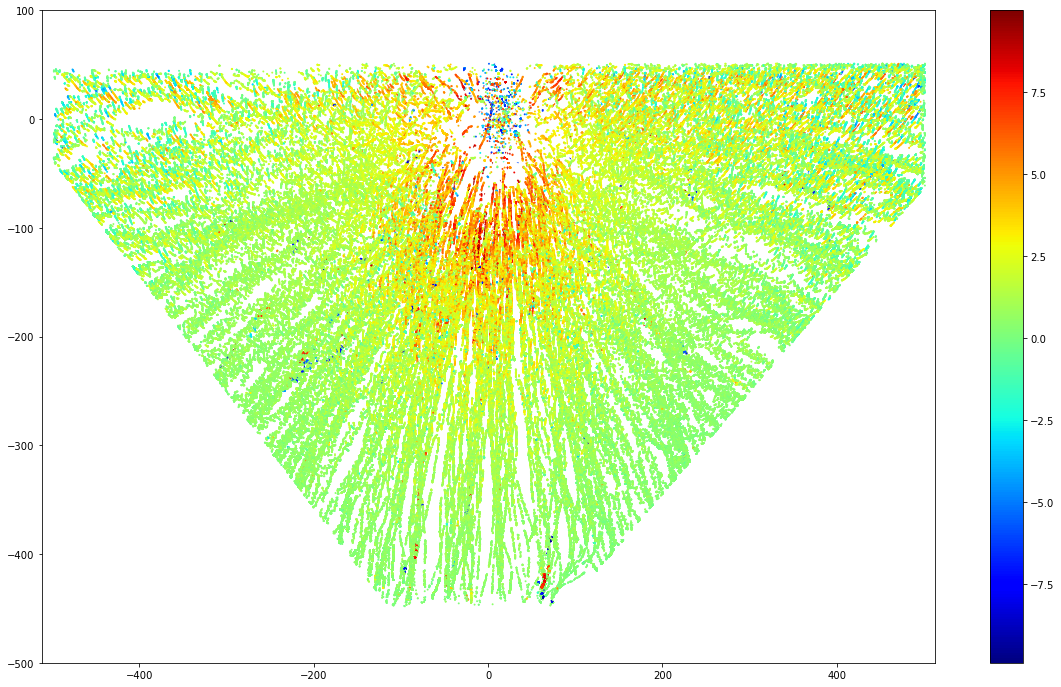

In [50]:
fig, ax = plt.subplots(figsize=(20, 12))
plt.xlim(-512, 512)
plt.ylim(-500, 100)
c = ax.quiver(ptv_result['x'], ptv_result['y'], ptv_result['dx'], ptv_result['dy'], ptv_result['dr'], cmap="jet")
fig.colorbar(c)
plt.show()

In [51]:
with open(f'ptv_cbi_q_20.pickle', mode='wb') as fp:
    pickle.dump(ptv_result, fp)

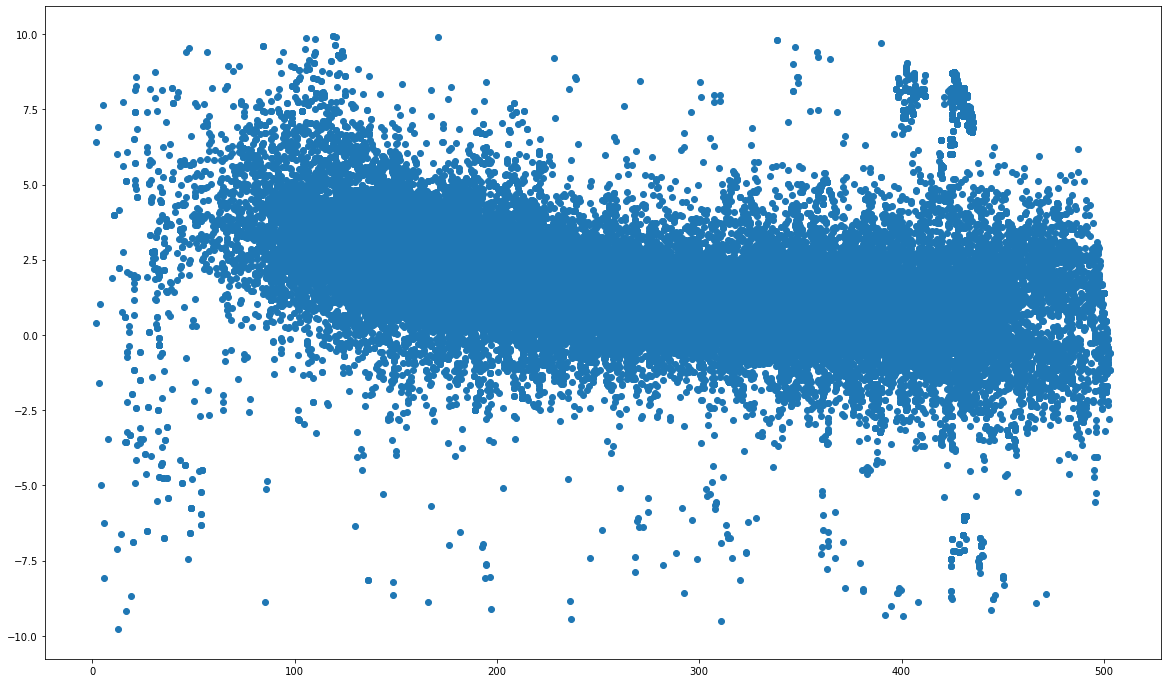

In [52]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(ptv_result['r'][::10], ptv_result['dr'][::10])
plt.show()

100%|██████████| 101/101 [00:01<00:00, 66.25it/s]


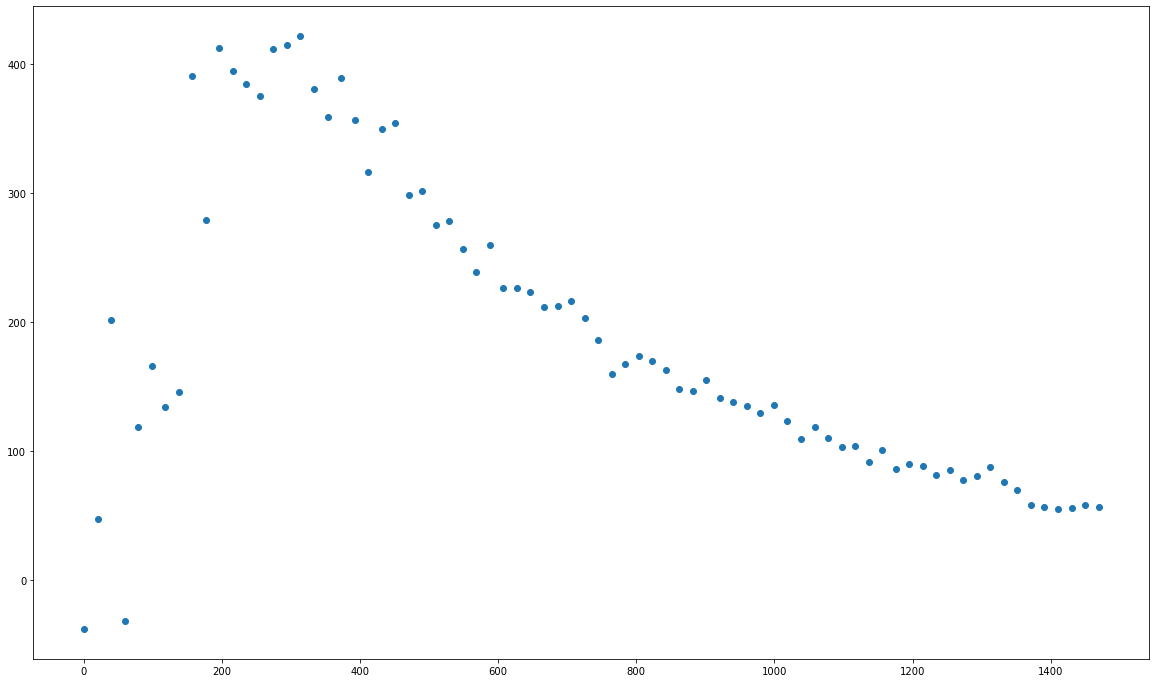

In [53]:
px2mm = 1000 / np.sqrt((498 - 488) ** 2 + (391 - 646) ** 2)
fps = 25
res_sort = ptv_result.sort_values(by='r', ascending=True).values
_iter = 50
res = []
res2 = []
r_dr_err = np.zeros((5001, 3))
r_dr_in = np.zeros((1, 2))
r_dr_err[:, :] = np.nan
r_dr_in[:, :] = np.nan

for i in tqdm(range(0, 5001, _iter)):
    res_sort_l = res_sort[np.where(res_sort[:, 4] >= i / 10)]
    res_sort_lr = res_sort_l[np.where(res_sort_l[:, 4] < (i + _iter) / 10)]
    columns = ['x', 'y', 'dx', 'dy', 'r', 'theta', 'dr']
    df = pd.DataFrame(data=res_sort_lr, columns=columns, dtype='float')
    q1 = df['dr'].quantile(0.25)
    q2 = df['dr'].quantile(0.75)
    iqr = q2 - q1

    upper = q2 + 1.5 * iqr
    bottom = q1 - 1.5 * iqr
    _in = df[(df['dr'] >= bottom) & (df['dr'] <= upper)].values
    tmp = np.array([_in[:, 4], _in[:, 6]]).T
    r_dr_in = np.vstack([r_dr_in, tmp])

    r_dr_err[i, 0] = i
    r_dr_err[i, 1] = np.mean(tmp, axis=0)[1]
    r_dr_err[i, 2] = np.std(tmp, axis=0)[1]

r_dr_err = r_dr_err[::_iter]
res = r_dr_err
res2 = r_dr_in
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(res[:-25, 0] * px2mm / 10, res[:-25, 1] * px2mm * fps)
plt.show()